<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xy/blob/main/large_template_coregister_xy.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
<a href="https://github.com/WinetraubLab/coregister-xy/blob/main/large_template_coregister_xy.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
Outputs a file with code block to copy paste into reconstruct_3d script, for one large template with all barcodes. Can process multiple slices at a time.

In [3]:
# @title Notebook Inputs { display-mode: "form" }
# @markdown [See Instructions](https://docs.google.com/document/d/1XAVQ2KHBn9OPUEbf9dRE8Kuds44gkQqYAzBNehx_rec/edit?usp=sharing) for instructions on how to get these values:
import numpy as np
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/')


# um_per_px = 5

# Units: px
fluorescent_csv_path = "coregister-xy/data/fluorescent-points.csv" # @param {type:"string"}

# Units: mm
template_csv_path = "coregister-xy/data/template-points.csv" # @param {type:"string"}

# This is the file where the plane_input.append() lines to copy paste into reconstruct_3d.ipynb will be written to
# Change as desired
output_file_path = "plane-inputs.txt"# @param {type:"string"}

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
# @title Environment Setup
!git clone https://github.com/WinetraubLab/coregister-xy.git
%cd coregister-xy

from plane.fit_template import FitTemplate
from plane.fit_plane import FitPlane
import matplotlib.pyplot as plt
import os
from google.colab import files
import math
import pandas as pd
import numpy as np

%cd ..

Cloning into 'coregister-xy'...
remote: Enumerating objects: 936, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 936 (delta 96), reused 65 (delta 56), pack-reused 778 (from 3)
Receiving objects: 100% (936/936), 2.27 MiB | 4.83 MiB/s, done.
Resolving deltas: 100% (579/579), done.
/content/coregister-xy
/content


In [14]:
# @title Compute mapping between fluorescent and template points
df = pd.read_csv(fluorescent_csv_path)
df_template = pd.read_csv(template_csv_path)

template_centers_uvz = {}
fluorescent_image_paths = {}
n_slices = df['Slice'].max()
slice_start = df['Slice'].min()

for idx in range(slice_start, n_slices + 1):
    template_centers_uvz[idx] = [
        (row['X'], row['Y'], row['Z']) for _, row in df[df['Slice'] == idx].iterrows()
    ]

for idx, row in df[df['fluorescent_image_path'].notna()].iterrows():
    fluorescent_image_paths[row['Slice']] = row['fluorescent_image_path']

template_centers_xy = [(row['X'], row['Y']) for _, row in df_template.iterrows()]

fps = []
template_centers_xyz_all_planes = []
template_centers_uv_all_planes = []
slide_idx = []

with open(output_file_path, "w") as outf:
  for idx in template_centers_uvz:
    z = np.array(template_centers_uvz[idx])[:,2] / 1000
    template_centers_uv = np.array(template_centers_uvz[idx])[:,:2]
    template_centers_xyz = np.hstack([np.array(template_centers_xy), z.reshape(-1, 1)])
    template_centers_xyz_all_planes.append(template_centers_xyz)
    template_centers_uv_all_planes.append(template_centers_uv)
    slide_idx.append(idx)

    fp = FitPlane.from_template_centers(template_centers_uv, template_centers_xyz, print_inputs = False)
    fps.append(fp)

    # In plane and out of plane erorr
    uv_to_xyz = np.array([fp.get_xyz_from_uv(x) for x in template_centers_uv])
    in_plane_err, out_plane_err = fp.get_template_center_positions_distance_metrics(template_centers_uv, template_centers_xyz)

    print("")
    print(f'Data for Slide {idx}:')
    print('---------------')
    print(f"Average in-plane mapping error: {in_plane_err*1000:.2f} um")
    print(f"Average out-of-plane mapping error: {out_plane_err*1000:.2f} um")
    print('---------------')
    print("fp = FitPlane.from_json('" + fp.to_json() + "')")
    print(f"\nplane_inputs.append({{\n\"uv_pix\": {template_centers_uv.tolist()},\n\"xyz_mm\": {template_centers_xyz.tolist()},\n\"image_file_path\": \"{fluorescent_image_paths[idx]}\"\n}})")
    print()
    # Write to single output file
    outf.write(f"\nplane_inputs.append({{\n\"uv_pix\": {template_centers_uv.tolist()},\n\"xyz_mm\": {template_centers_xyz.tolist()},\n\"image_file_path\": \"{fluorescent_image_paths[idx]}\"\n}})")


Data for Slide 1:
---------------
Average in-plane mapping error: 3.11 um
Average out-of-plane mapping error: 0.00 um
---------------
fp = FitPlane.from_json('{"u": [0.0011416598899054863, -0.00025480858765866644, -3.947921138740263e-18], "v": [0.00024464918873106723, 0.0011815149343924036, 1.1968748954140742e-18], "h": [-0.9705803366672346, -0.05476643176799694, 0.02400000000000012]}')

plane_inputs.append({
"uv_pix": [[1927, 767], [1874, 991], [2098, 847], [2588, 1759], [2536, 1976], [2764, 1835]],
"xyz_mm": [[1.41331, 0.36551, 0.024], [1.41237, 0.63636, 0.024], [1.63543, 0.40769, 0.024], [2.41143, 1.36551, 0.024], [2.40956, 1.63355, 0.024], [2.63449, 1.40862, 0.024]],
"image_file_path": "/content/drive/Shareddrives/Yolab - Current Projects/Zerlina/_Data/r2s1s4.tif"
})


Data for Slide 2:
---------------
Average in-plane mapping error: 2.53 um
Average out-of-plane mapping error: 0.11 um
---------------
fp = FitPlane.from_json('{"u": [0.0011750234729282821, -6.519486492980627e-05, 1.

In [5]:
outf.close()
print(f"See output file {output_file_path} for plane_input lines to copy into the reconstruct_3d.ipynb script!")

See output file plane-inputs.txt for plane_input lines to copy into the reconstruct_3d.ipynb script!


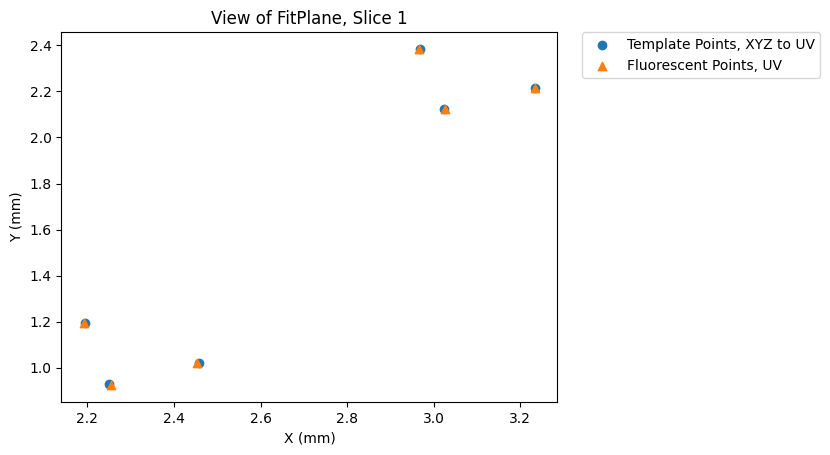

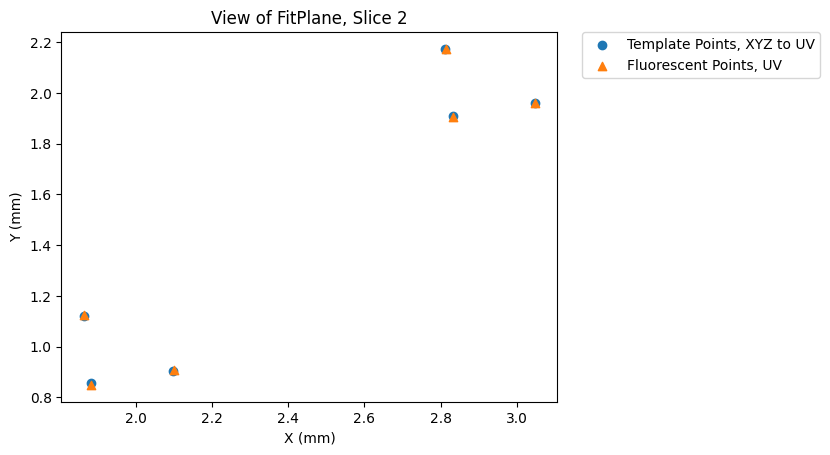

In [15]:
# Plot, in um
for idx, slide_num in enumerate(slide_idx):
  template_centers_xyz = template_centers_xyz_all_planes[idx]
  template_centers_uv = template_centers_uv_all_planes[idx]
  fp = fps[idx]
  a = np.array([fp.get_uv_from_xyz(t) for t in template_centers_xyz])
  plt.scatter(a[:,0] * fp.u_norm_mm(), a[:,1] * fp.v_norm_mm(), label="Template Points, XYZ to UV")
  plt.scatter(template_centers_uv[:, 0] * fp.u_norm_mm(), template_centers_uv[:, 1] * fp.v_norm_mm(), label="Fluorescent Points, UV",marker='^')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.xlabel("X (mm)")
  plt.ylabel("Y (mm)")
  plt.title(f"View of FitPlane, Slice {slide_num}")
  plt.show()